In [2]:

import numpy as np
import torchvision
from torchvision.transforms import v2
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import skimage.color
from torch.nn.functional import relu, tanh


/cs/cs152/venv/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/cs/cs152/venv/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue:

In [3]:
class RGB2LAB(torch.nn.Module):
    def forward(self, img):  # we assume inputs are always structured like this
        # print(img.shape)
        lab_image = skimage.color.rgb2lab(img)
        # Do some transformations. Here, we're just passing though the input
        return lab_image

class LAB2RGB(torch.nn.Module):
    def forward(self, img):  # we assume inputs are always structured like this
        rgb_image = skimage.color.lab2rgb(img)
        # Do some transformations. Here, we're just passing though the input
        return rgb_image

def split_norm(lab_img):
    # return lab_img[:][0]/50 - 1, lab_img[:][1, 2]/120
    # return torch.select(lab_img, 1, 0)
    
    return torch.unsqueeze(lab_img[:, 0, :, :]/50 - 1, 1), lab_img[:, (1,2), :, :]/100

def merge_denorm(l, ab):
    # return lab_img[:][0]/50 - 1, lab_img[:][1, 2]/120
    # return torch.select(lab_img, 1, 0)
    l = (l + 1)*50
    ab = ab*100
    return torch.cat((l, ab), 1)

In [4]:

transform = v2.Compose(
    [
     RGB2LAB(),
     v2.ToTensor(),
     v2.ToDtype(torch.float32),
     
     v2.Resize((80, 80))],
    )


training_set = torchvision.datasets.LFWPeople('/cs/cs152/individual/treddy/celeb', split='train', transform=transform, download=True)
validation_set = torchvision.datasets.LFWPeople('/cs/cs152/individual/treddy/celeb2', split='test', transform=transform, download=True)
# training_set = torchvision.datasets.OxfordIIITPet('/cs/cs152/individual/treddy/pet', split='trainval', transform=transform, download=True)
# validation_set = torchvision.datasets.OxfordIIITPet('/cs/cs152/individual/treddy/pet2', split='test', transform=transform, download=True)

obama = torchvision.io.read_image('obama.jpg')
# obama = obama[None, :, :, :]
obama = torch.transpose(obama, 0, 2)

obama = transform(obama)

/cs/cs152/venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


/cs/cs152/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(-1.)
tensor(-0.1492)


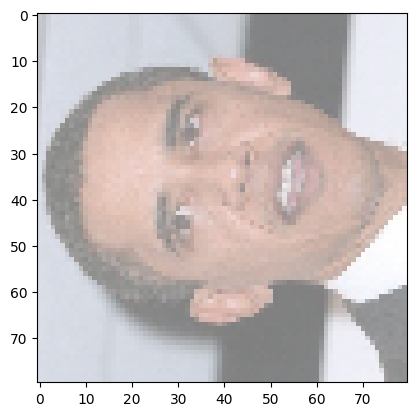

In [7]:

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

rgb_transforms = v2.Compose([
    # v2.ToPILImage(),
    LAB2RGB(),
    v2.ToImageTensor(),
])



# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        print('1c')
        plt.imshow(npimg, cmap="Greys")
    else:
        # print('a')
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(training_loader)
images, labels = next(dataiter)
rgb_images = []
images = obama[None, :, :, :]
# print(images.shape)
# print(type(images))
# print(len(split_norm(images)))
l, ab = split_norm(images)
print(torch.min(l))
print(torch.min(ab))
# print(l.shape)
# print(ab.shape)
labs = merge_denorm(l, ab)
for i in range(len(images)):
    # print(images[i].shape)
    rgb_images.append(rgb_transforms(labs[i].permute(1, 2, 0)))



# g_images =rgb_transforms(images)

# # Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(rgb_images)
matplotlib_imshow(img_grid, one_channel=False)

# print('  '.join(classes[labels[j]] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


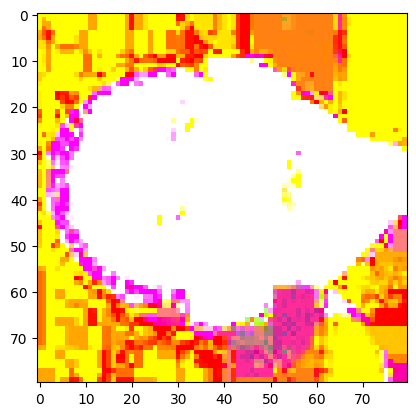

In [8]:
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)

In [9]:



# NOTE: This UNet was more or less copied from 
# https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    # input is a 64x64x1
    self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # out = 64x64x64
    self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # out = 32x32x64

    self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output = 32x32x128
    self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 32x32x128
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output= 16x16x128

    self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output= 16x16x256
    self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) #
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x256

    self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output 8x8x512
    self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #4x4x512

    self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
    self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


    self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
    self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

    self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

    self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

    self.outconv = nn.Conv2d(64, 2, kernel_size=1)


  def forward(self, x):
    out_e11 = relu(self.e11(x))
    out_e12 = relu(self.e12(out_e11))
    out_ep1 = self.pool1(out_e12)

    out_e21 = relu(self.e21(out_ep1))
    out_e22 = relu(self.e22(out_e21))
    out_p2 = self.pool2(out_e22)

    out_e31 = relu(self.e31(out_p2))
    out_e32 = relu(self.e32(out_e31))
    out_p3 = self.pool3(out_e32)

    out_e41 = relu(self.e41(out_p3))
    out_e42 = relu(self.e42(out_e41))
    out_p4 = self.pool3(out_e42)

    out_e51 = relu(self.e51(out_p4))
    out_e52 = relu(self.e52(out_e51))


        # Decoder
    out_u1 = self.upconv1(out_e52)
    # print(out_u1.shape)
    # print(out_e42.shape)
    out_u11 = torch.cat([out_u1, out_e42], dim=1)
    out_d11 = relu(self.d11(out_u11))
    out_d12 = relu(self.d12(out_d11))

    out_u2 = self.upconv2(out_d12)
    out_u22 = torch.cat([out_u2, out_e32], dim=1)
    out_d21 = relu(self.d21(out_u22))
    out_d22 = relu(self.d22(out_d21))

    out_u3 = self.upconv3(out_d22)
    out_u33 = torch.cat([out_u3, out_e22], dim=1)
    out_d31 = relu(self.d31(out_u33))
    out_d32 = relu(self.d32(out_d31))

    out_u4 = self.upconv4(out_d32)
    out_u43 = torch.cat([out_u4, out_e12], dim=1)
    out_d41 = relu(self.d41(out_u43))
    out_d42 = relu(self.d42(out_d41))

    #
        # Output layer
    out = self.outconv(out_d42)
    # out = tanh(out1)

    return out



In [10]:

model = UNet()
model.to(device)
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.RMSprop(params = model.parameters(), lr=0.000001, momentum = 0.02)
# optimizer = torch.optim.Adam(params = model.parameters(), lr=0.000002 )


In [11]:
# modified code from pytorch documentation
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.


    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        colored, _ = data
        colored = colored.cuda()
        # print(colored.shape)
        grey, label = split_norm(colored)
        # print(grey.shape)
        # print(colored.shape)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # print(grey.shape)
        # Make predictions for this batch
        outputs = model(grey)
        # print(outputs.shape)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, label)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))

            running_loss = 0.

    return last_loss

In [12]:
# modified code from pytorch documentation
epoch_number = 0

EPOCHS = 50

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))


    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0

    model.eval()


    with torch.no_grad():
        # for i, vdata in enumerate(validation_loader):
        for i, vdata in enumerate(validation_loader):
            # vinputs, vlabels = vdata
            vcolored, vlabels = vdata
            vcolored = vcolored.cuda()
            vgrey, vlabel = split_norm(vcolored)
            voutputs = model(vgrey)
            vloss = loss_fn(voutputs, vlabel)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        # torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 200 loss: 0.018465339879039675
  batch 400 loss: 0.017538113780319692
  batch 600 loss: 0.017276100150775166
  batch 800 loss: 0.01707673774799332
  batch 1000 loss: 0.01707173591013998
  batch 1200 loss: 0.015889066627714783
  batch 1400 loss: 0.0164450323744677
  batch 1600 loss: 0.01672253481345251
  batch 1800 loss: 0.015974699046928435
  batch 2000 loss: 0.01678532230434939
  batch 2200 loss: 0.01611708793323487
LOSS train 0.01611708793323487 valid 0.015660857781767845
EPOCH 2:
  batch 200 loss: 0.015515112918801605
  batch 400 loss: 0.015235721303615718
  batch 600 loss: 0.015432023247703909
  batch 800 loss: 0.015803885953500865
  batch 1000 loss: 0.014964988820720464
  batch 1200 loss: 0.014572640039259567
  batch 1400 loss: 0.015277658281847835
  batch 1600 loss: 0.015050990753807128
  batch 1800 loss: 0.01532469437806867
  batch 2000 loss: 0.015318614912685007
  batch 2200 loss: 0.015591070142108946
LOSS train 0.015591070142108946 valid 0.014884458854794502
E

KeyboardInterrupt: 

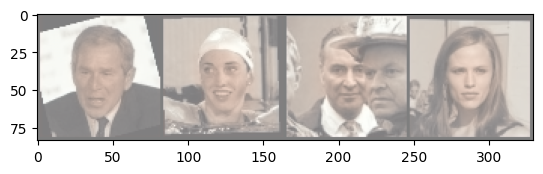

In [13]:
colored, labels = next(dataiter)

grey, label = split_norm(colored)

abs = model(grey.cuda())

labs = merge_denorm(grey.cuda(), abs)
labs = labs.cpu()
rgb_images = []
for i in range(len(abs)):
    # print(images[i].shape)
    rgb_images.append(rgb_transforms(labs[i].permute(1, 2, 0).detach().numpy()))


labs = merge_denorm(grey, label)
glabs = merge_denorm(grey, torch.zeros_like(label))
labs = labs.cpu()
true_images = []
for i in range(len(abs)):
    # print(images[i].shape)
    true_images.append(rgb_transforms(labs[i].permute(1, 2, 0).detach().numpy()))


grey_images = []
for i in range(len(abs)):
    # print(images[i].shape)
    grey_images.append(rgb_transforms(glabs[i].permute(1, 2, 0).detach().numpy()))


# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(rgb_images)
matplotlib_imshow(img_grid, one_channel=False)

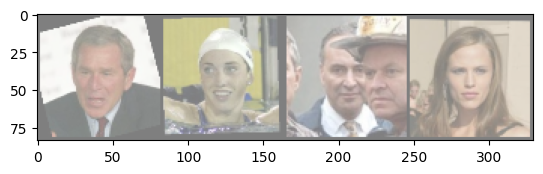

In [14]:
img_grid = torchvision.utils.make_grid(true_images)
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:
img_grid = torchvision.utils.make_grid(grey_images)
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:
torch.save(model, "'model4.pt'")